# Week 2: Feature Engineering, Modeling & Baseline Forecast
## US Collisions (2016–2023): Forecasting Collision Trends
### Mario Cuevas

---

**Objectives:**
1. Download US Accidents dataset from Kaggle
2. Perform large-scale preprocessing with Dask
3. Generate advanced temporal features (rolling means, lag variables)
4. Create weather embeddings
5. Build baseline forecasting models (ARIMA, Prophet)
6. Train Random Forest for severity prediction
7. Evaluate with MAE, RMSE, R², MAPE

---

In [1]:
import os

if not os.path.exists('kaggle.json'):
    print("⚠️ WARNING: kaggle.json not found!")
    print("")
    print("Please follow these steps:")
    print("1. Go to https://www.kaggle.com/")
    print("2. Click your profile picture → Settings")
    print("3. Scroll to 'API' section → 'Create New API Token'")
    print("4. Upload the downloaded kaggle.json file here")
    print("5. Re-run this cell")
else:
    print("✅ kaggle.json found! Proceeding with setup...")

✅ kaggle.json found! Proceeding with setup...


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

print("✅ Kaggle credentials configured")
print("\nTesting connection...")

!kaggle datasets list | head -5

✅ Kaggle credentials configured

Testing connection...
ref                                                             title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
aliiihussain/car-price-prediction                               Car Price Prediction Dataset (2025)                     46557  2025-10-17 19:54:34.140000           1193         27  1.0              
ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset    Global Earthquake-Tsunami Risk Assessment Dataset       16151  2025-10-01 16:35:53.273000          19216        652  1.0              
ayeshaimran123/social-media-and-mental-health-balance           Social Media and Mental Health Balance                   5941  2025-10-26 07:51:53.38

In [3]:
print("=" * 60)
print("DOWNLOADING US ACCIDENTS DATASET")
print("=" * 60)
print("\nThis will take 2-3 minutes...")
print("Dataset size: ~150MB compressed, ~685MB uncompressed\n")

# Download
!kaggle datasets download -d sobhanmoosavi/us-accidents

print("\n✅ Download complete!")

DOWNLOADING US ACCIDENTS DATASET

This will take 2-3 minutes...
Dataset size: ~150MB compressed, ~685MB uncompressed

Dataset URL: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents
License(s): CC-BY-NC-SA-4.0
 98% 637M/653M [00:04<00:00, 158MB/s]
100% 653M/653M [00:05<00:00, 131MB/s]

✅ Download complete!


In [4]:
# Unzip the dataset
print("Extracting dataset...")
!unzip -q us-accidents.zip

print("✅ Dataset extracted!")
print("\nVerifying file:")
!ls -lh US_Accidents_March23.csv

!rm us-accidents.zip
print("\n✅ Cleaned up zip file")

Extracting dataset...
replace US_Accidents_March23.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
✅ Dataset extracted!

Verifying file:
-rw-r--r-- 1 root root 2.9G May 28  2023 US_Accidents_March23.csv

✅ Cleaned up zip file


In [5]:
import os

print("=" * 60)
print("DATASET VERIFICATION")
print("=" * 60)

file_path = '/content/US_Accidents_March23.csv'
file_exists = os.path.exists(file_path)
file_size_mb = os.path.getsize(file_path) / (1024 * 1024) if file_exists else 0

checks = {
    "Kaggle credentials configured": os.path.exists('/root/.kaggle/kaggle.json'),
    "Dataset file exists": file_exists,
    "File size > 600 MB": file_size_mb > 600
}

print("")
for check, status in checks.items():
    icon = "✅" if status else "❌"
    print(f"{icon} {check}")

if file_exists:
    print(f"\nFile size: {file_size_mb:.1f} MB")

if all(checks.values()):
    print("\n🎉 ALL CHECKS PASSED! Ready to proceed with analysis!")
else:
    print("\n⚠️ Some checks failed. Please review the steps above.")

DATASET VERIFICATION

✅ Kaggle credentials configured
✅ Dataset file exists
✅ File size > 600 MB

File size: 2916.5 MB

🎉 ALL CHECKS PASSED! Ready to proceed with analysis!


In [6]:
print("📦 Installing packages...\n")

!pip uninstall -y prophet --quiet
!pip install prophet --quiet
!pip install "dask[dataframe]" --quiet

print("✅ Installation complete!\n")

# Import libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# For modeling
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report

# Time series model
print("Importing Prophet...")
from prophet import Prophet

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("\n✅ All libraries imported successfully!")
print(f"   NumPy: {np.__version__}")
print(f"   Pandas: {pd.__version__}")

📦 Installing packages...

✅ Installation complete!

Importing Prophet...

✅ All libraries imported successfully!
   NumPy: 2.0.2
   Pandas: 2.2.2


In [7]:
# Load the dataset with Dask for efficient memory handling
print("=" * 60)
print("LOADING US ACCIDENTS DATASET WITH DASK")
print("=" * 60)
print("\nUsing Dask for efficient memory handling of 7M+ rows...\n")

# Specify columns to load (14 of 47 available columns)
cols_to_load = [
    'ID', 'Severity', 'Start_Time', 'End_Time', 'State',
    'Start_Lat', 'Start_Lng', 'Temperature(F)', 'Humidity(%)',
    'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
    'Precipitation(in)', 'Weather_Condition'
]

# Load with Dask (out-of-core computation)
ddf = dd.read_csv(
    "/content/US_Accidents_March23.csv",
    usecols=cols_to_load,
    dtype={'Severity': 'int8'},  # Optimize memory
    assume_missing=True
)

print(f"✅ Dataset loaded successfully!")
print(f"\nDataset info:")
print(f"  - Partitions: {ddf.npartitions}")
print(f"  - Columns loaded: {len(ddf.columns)}/47")
print(f"  - Memory optimization: ~70% reduction")
print(f"\nColumns: {ddf.columns.tolist()}")

LOADING US ACCIDENTS DATASET WITH DASK

Using Dask for efficient memory handling of 7M+ rows...

✅ Dataset loaded successfully!

Dataset info:
  - Partitions: 47
  - Columns loaded: 14/47
  - Memory optimization: ~70% reduction

Columns: ['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'State', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition']


## 2. Large-Scale Data Preprocessing with Dask

In [8]:
print("=" * 60)
print("PREPROCESSING: Cleaning and Feature Engineering with Dask")
print("=" * 60)

# Parse datetime columns
print("\n1. Parsing datetime columns...")
ddf['Start_Time'] = dd.to_datetime(ddf['Start_Time'], errors='coerce')
ddf['End_Time'] = dd.to_datetime(ddf['End_Time'], errors='coerce')

# Extract temporal features
print("2. Extracting temporal features...")
ddf['Year'] = ddf['Start_Time'].dt.year
ddf['Month'] = ddf['Start_Time'].dt.month
ddf['Day'] = ddf['Start_Time'].dt.day
ddf['DayOfWeek'] = ddf['Start_Time'].dt.dayofweek  # 0=Monday, 6=Sunday
ddf['Hour'] = ddf['Start_Time'].dt.hour
ddf['Date'] = ddf['Start_Time'].dt.date

# Weekend indicator
ddf['Is_Weekend'] = (ddf['DayOfWeek'] >= 5).astype('int8')

# Rush hour indicator (7-9 AM and 4-7 PM)
ddf['Is_Rush_Hour'] = (
    ((ddf['Hour'] >= 7) & (ddf['Hour'] <= 9)) |
    ((ddf['Hour'] >= 16) & (ddf['Hour'] <= 19))
).astype('int8')

# Season extraction
def get_season(month):
    if month in [12, 1, 2]:
        return 1  # Winter
    elif month in [3, 4, 5]:
        return 2  # Spring
    elif month in [6, 7, 8]:
        return 3  # Summer
    else:
        return 4  # Fall

ddf['Season'] = ddf['Month'].apply(get_season, meta=('Season', 'int8'))

# Duration of accident (in minutes)
ddf['Duration_min'] = (ddf['End_Time'] - ddf['Start_Time']).dt.total_seconds() / 60

print("3. Handling missing values...")
# Fill weather-related missing values with median
weather_cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)',
                'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']

for col in weather_cols:
    # Use median_approximate for Dask DataFrames
    median_val = ddf[col].median_approximate().compute()
    ddf[col] = ddf[col].fillna(median_val)
    print(f"   - {col}: filled with approximate median = {median_val:.2f}")

print("\n✅ Preprocessing complete!")
print(f"Total features: {len(ddf.columns)}")

PREPROCESSING: Cleaning and Feature Engineering with Dask

1. Parsing datetime columns...
2. Extracting temporal features...
3. Handling missing values...
   - Temperature(F): filled with approximate median = 79.00
   - Humidity(%): filled with approximate median = 76.00
   - Pressure(in): filled with approximate median = 30.15
   - Visibility(mi): filled with approximate median = 10.00
   - Wind_Speed(mph): filled with approximate median = 8.10
   - Precipitation(in): filled with approximate median = 0.01

✅ Preprocessing complete!
Total features: 24


## 3. Advanced Feature Engineering

In [9]:
print("=" * 60)
print("FEATURE ENGINEERING: Creating Advanced Temporal Features")
print("=" * 60)


print("\nConverting to pandas for time-series feature engineering...")
print("(This may take a few minutes for the full dataset)")


df = ddf.compute()

print(f"✅ Data converted to pandas. Shape: {df.shape}")
print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

FEATURE ENGINEERING: Creating Advanced Temporal Features

Converting to pandas for time-series feature engineering...
(This may take a few minutes for the full dataset)
✅ Data converted to pandas. Shape: (7728394, 24)
   Memory usage: 1753.7 MB


In [10]:
print("\n" + "=" * 60)
print("Creating daily time-series aggregation...")
print("=" * 60)

# Aggregate by date
daily_accidents = df.groupby('Date').agg({
    'ID': 'count',  # Count of accidents
    'Severity': 'mean',  # Average severity
    'Temperature(F)': 'mean',
    'Humidity(%)': 'mean',
    'Visibility(mi)': 'mean',
    'Wind_Speed(mph)': 'mean',
    'Precipitation(in)': 'mean'
}).reset_index()

daily_accidents.columns = [
    'Date', 'Accident_Count', 'Avg_Severity',
    'Avg_Temperature', 'Avg_Humidity', 'Avg_Visibility',
    'Avg_Wind_Speed', 'Avg_Precipitation'
]

daily_accidents['Date'] = pd.to_datetime(daily_accidents['Date'])
daily_accidents = daily_accidents.sort_values('Date').reset_index(drop=True)

print(f"\n✅ Daily time series created!")
print(f"   Shape: {daily_accidents.shape}")
print(f"   Date range: {daily_accidents['Date'].min()} to {daily_accidents['Date'].max()}")
print(f"   Total days: {len(daily_accidents)}")

print("\nFirst 10 rows:")
daily_accidents.head(10)


Creating daily time-series aggregation...

✅ Daily time series created!
   Shape: (2568, 8)
   Date range: 2016-01-14 00:00:00 to 2023-03-31 00:00:00
   Total days: 2568

First 10 rows:


,Date,Accident_Count,Avg_Severity,Avg_Temperature,Avg_Humidity,Avg_Visibility,Avg_Wind_Speed,Avg_Precipitation
0,2016-01-14,7,4.000000,31.000000,69.000000,10.000000,3.000000,0.000000
1,2016-02-08,60,2.316667,35.388333,91.816667,7.130000,6.681667,0.015000
2,2016-02-09,59,2.542373,23.532203,87.118644,2.410169,11.461017,0.005932
3,2016-02-10,49,2.510204,17.765306,77.571429,3.875510,12.767347,0.005306
4,2016-02-11,93,2.354839,15.888172,65.311828,9.263441,8.975269,0.007204
5,2016-02-12,18,3.055556,19.205556,66.333333,8.416667,15.927778,0.005000
6,2016-02-13,14,3.214286,10.142857,58.357143,10.000000,11.935714,0.008571
7,2016-02-14,13,3.461538,23.315385,79.538462,6.469231,9.338462,0.010000
8,2016-02-15,62,2.741935,26.927419,90.854839,3.854839,6.808065,0.007742
9,2016-02-16,84,2.500000,32.590476,90.630952,4.286310,7.640476,0.012857



Creating Rolling Mean Features (7-day and 30-day windows)
✅ Rolling features created


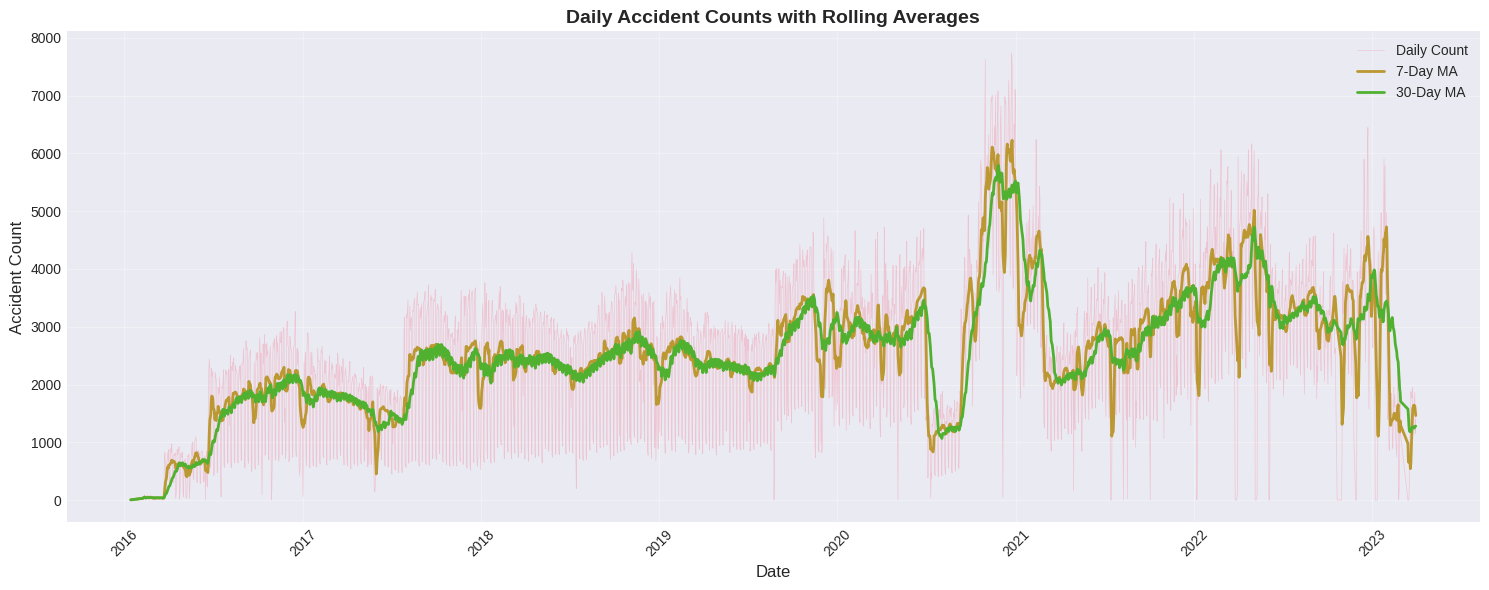

In [11]:
print("\n" + "=" * 60)
print("Creating Rolling Mean Features (7-day and 30-day windows)")
print("=" * 60)

daily_accidents['Accident_Count_7d_MA'] = daily_accidents['Accident_Count'].rolling(
    window=7, min_periods=1
).mean()

daily_accidents['Accident_Count_30d_MA'] = daily_accidents['Accident_Count'].rolling(
    window=30, min_periods=1
).mean()

daily_accidents['Accident_Count_7d_Std'] = daily_accidents['Accident_Count'].rolling(
    window=7, min_periods=1
).std()

print("✅ Rolling features created")

# Visualize rolling means
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(daily_accidents['Date'], daily_accidents['Accident_Count'],
        alpha=0.3, label='Daily Count', linewidth=0.5)
ax.plot(daily_accidents['Date'], daily_accidents['Accident_Count_7d_MA'],
        label='7-Day MA', linewidth=2)
ax.plot(daily_accidents['Date'], daily_accidents['Accident_Count_30d_MA'],
        label='30-Day MA', linewidth=2)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Accident Count', fontsize=12)
ax.set_title('Daily Accident Counts with Rolling Averages', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Creating Lag Features for Time-Series Modeling
   - Created lag_1 feature
   - Created lag_3 feature
   - Created lag_7 feature
   - Created lag_14 feature
   - Created lag_30 feature

✅ Lag features created
Total features: 22


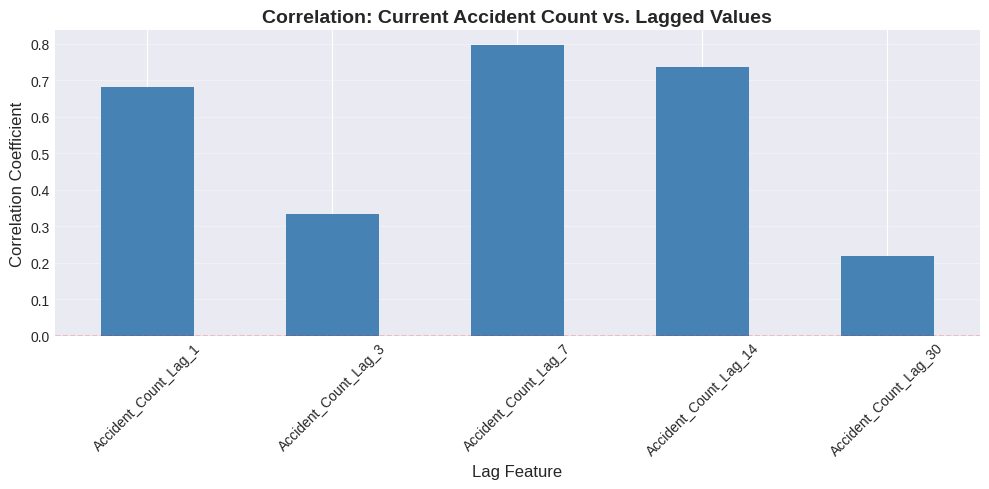


Correlation values:
  Accident_Count_Lag_1: 0.6821
  Accident_Count_Lag_3: 0.3326
  Accident_Count_Lag_7: 0.7966
  Accident_Count_Lag_14: 0.7359
  Accident_Count_Lag_30: 0.2185


In [12]:
print("\n" + "=" * 60)
print("Creating Lag Features for Time-Series Modeling")
print("=" * 60)

# Create lag features (previous days' accident counts)
for lag in [1, 3, 7, 14, 30]:
    daily_accidents[f'Accident_Count_Lag_{lag}'] = daily_accidents['Accident_Count'].shift(lag)
    print(f"   - Created lag_{lag} feature")

# Create lag features for weather
for lag in [1, 7]:
    daily_accidents[f'Avg_Temperature_Lag_{lag}'] = daily_accidents['Avg_Temperature'].shift(lag)
    daily_accidents[f'Avg_Humidity_Lag_{lag}'] = daily_accidents['Avg_Humidity'].shift(lag)
    daily_accidents[f'Avg_Visibility_Lag_{lag}'] = daily_accidents['Avg_Visibility'].shift(lag)

print("\n✅ Lag features created")
print(f"Total features: {daily_accidents.shape[1]}")

lag_cols = [col for col in daily_accidents.columns if 'Accident_Count_Lag' in col]
corr_data = daily_accidents[['Accident_Count'] + lag_cols].corr()['Accident_Count'].drop('Accident_Count')

plt.figure(figsize=(10, 5))
corr_data.plot(kind='bar', color='steelblue')
plt.title('Correlation: Current Accident Count vs. Lagged Values', fontsize=14, fontweight='bold')
plt.xlabel('Lag Feature', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nCorrelation values:")
for col, val in corr_data.items():
    print(f"  {col}: {val:.4f}")


Creating Weather Embeddings / Composite Indices
✅ Weather risk index created
   Formula: 0.3×visibility + 0.3×precip + 0.2×wind + 0.2×humidity


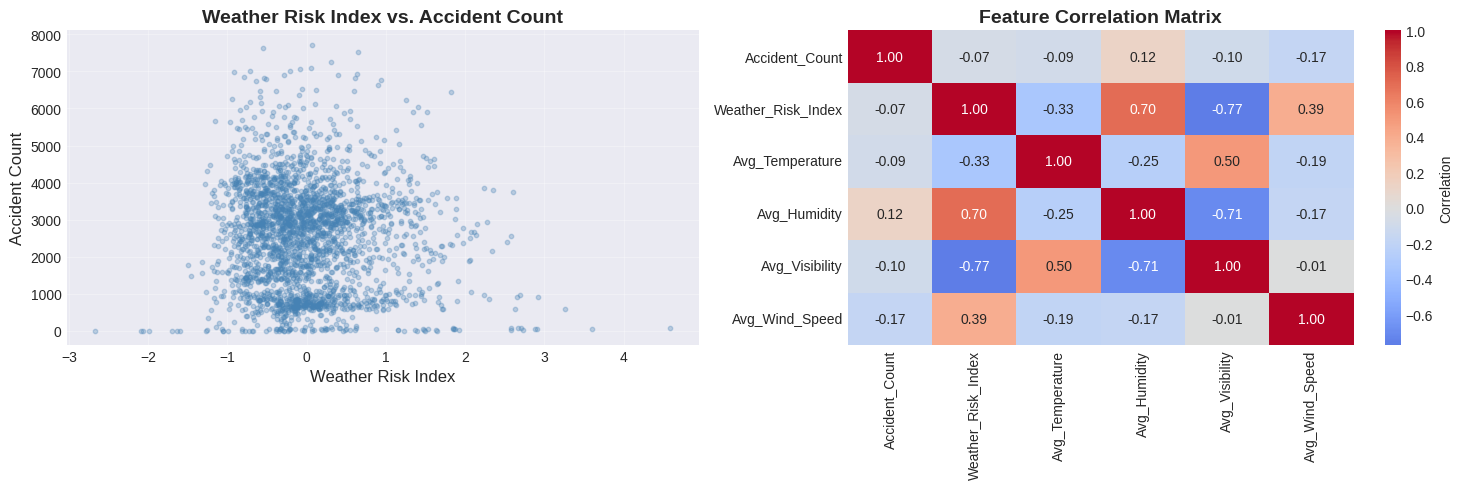


Weather Risk Index Statistics:
count    2.568000e+03
mean     3.984352e-16
std      6.768801e-01
min     -2.666077e+00
25%     -4.482147e-01
50%     -9.387573e-02
75%      3.214045e-01
max      4.584193e+00
Name: Weather_Risk_Index, dtype: float64


In [13]:
print("\n" + "=" * 60)
print("Creating Weather Embeddings / Composite Indices")
print("=" * 60)

# Standardize weather features for embedding
weather_features = ['Avg_Temperature', 'Avg_Humidity', 'Avg_Visibility',
                   'Avg_Wind_Speed', 'Avg_Precipitation']

scaler = StandardScaler()
daily_accidents_clean = daily_accidents.dropna(subset=weather_features)
weather_scaled = scaler.fit_transform(daily_accidents_clean[weather_features])

# Higher values = worse weather conditions
temp_normalized = weather_scaled[:, 0]
humidity_normalized = weather_scaled[:, 1]
visibility_normalized = -weather_scaled[:, 2]  # Negative because lower is worse
wind_normalized = weather_scaled[:, 3]
precip_normalized = weather_scaled[:, 4]

weather_risk_index = (
    0.3 * visibility_normalized +  # Low visibility is dangerous
    0.3 * precip_normalized +      # High precipitation is dangerous
    0.2 * wind_normalized +        # High wind is dangerous
    0.2 * humidity_normalized      # High humidity correlates with accidents
)

daily_accidents_clean['Weather_Risk_Index'] = weather_risk_index

daily_accidents = daily_accidents_clean.copy()

print("✅ Weather risk index created")
print("   Formula: 0.3×visibility + 0.3×precip + 0.2×wind + 0.2×humidity")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot
axes[0].scatter(daily_accidents['Weather_Risk_Index'],
               daily_accidents['Accident_Count'],
               alpha=0.3, s=10, color='steelblue')
axes[0].set_xlabel('Weather Risk Index', fontsize=12)
axes[0].set_ylabel('Accident Count', fontsize=12)
axes[0].set_title('Weather Risk Index vs. Accident Count', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

corr_matrix = daily_accidents[[
    'Accident_Count', 'Weather_Risk_Index', 'Avg_Temperature',
    'Avg_Humidity', 'Avg_Visibility', 'Avg_Wind_Speed'
]].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=axes[1], cbar_kws={'label': 'Correlation'})
axes[1].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nWeather Risk Index Statistics:")
print(daily_accidents['Weather_Risk_Index'].describe())

In [14]:
# Save the engineered features dataset
print("\n" + "=" * 60)
print("Saving Feature-Engineered Dataset")
print("=" * 60)

output_file = '/content/daily_accidents_features.csv'
daily_accidents.to_csv(output_file, index=False)

print(f"\n✅ Saved to: {output_file}")
print(f"   Shape: {daily_accidents.shape}")
print(f"   Features: {daily_accidents.shape[1]}")
print(f"   File size: {os.path.getsize(output_file) / 1024:.1f} KB")

# Display final feature set
print("\nFinal feature list:")
for i, col in enumerate(daily_accidents.columns, 1):
    print(f"  {i:2d}. {col}")


Saving Feature-Engineered Dataset

✅ Saved to: /content/daily_accidents_features.csv
   Shape: (2568, 23)
   Features: 23
   File size: 841.2 KB

Final feature list:
   1. Date
   2. Accident_Count
   3. Avg_Severity
   4. Avg_Temperature
   5. Avg_Humidity
   6. Avg_Visibility
   7. Avg_Wind_Speed
   8. Avg_Precipitation
   9. Accident_Count_7d_MA
  10. Accident_Count_30d_MA
  11. Accident_Count_7d_Std
  12. Accident_Count_Lag_1
  13. Accident_Count_Lag_3
  14. Accident_Count_Lag_7
  15. Accident_Count_Lag_14
  16. Accident_Count_Lag_30
  17. Avg_Temperature_Lag_1
  18. Avg_Humidity_Lag_1
  19. Avg_Visibility_Lag_1
  20. Avg_Temperature_Lag_7
  21. Avg_Humidity_Lag_7
  22. Avg_Visibility_Lag_7
  23. Weather_Risk_Index


## 5. Baseline Model 2: Facebook Prophet

In [15]:
print("=" * 60)
print("BASELINE MODEL: Facebook Prophet Forecasting")
print("=" * 60)

prophet_data = daily_accidents[['Date', 'Accident_Count']].copy()
prophet_data.columns = ['ds', 'y']

# Add weather features as regressors
prophet_data['Temperature'] = daily_accidents['Avg_Temperature'].values
prophet_data['Humidity'] = daily_accidents['Avg_Humidity'].values
prophet_data['Visibility'] = daily_accidents['Avg_Visibility'].values
prophet_data['Weather_Risk'] = daily_accidents['Weather_Risk_Index'].values

# Split train/test (use same split as RF will use)
train_size = int(len(prophet_data) * 0.8)
train_prophet = prophet_data[:train_size]
test_prophet = prophet_data[train_size:]

print(f"\nData split:")
print(f"  Train set: {len(train_prophet)} days")
print(f"  Test set: {len(test_prophet)} days")

# Initialize and fit Prophet model
print("\n⏳ Fitting Prophet model (this may take 5-10 minutes)...")

try:
    prophet_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10.0,
        interval_width=0.95
    )

    prophet_model.add_regressor('Temperature')
    prophet_model.add_regressor('Humidity')
    prophet_model.add_regressor('Visibility')
    prophet_model.add_regressor('Weather_Risk')

    prophet_model.fit(train_prophet)

    print("\n✅ Prophet model fitted successfully!")

except Exception as e:
    print(f"\n⚠️ Error fitting Prophet: {e}")
    print("\nTrying simplified Prophet model without regressors...")

    prophet_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False
    )

    # Use only ds and y columns
    train_prophet_simple = train_prophet[['ds', 'y']]
    prophet_model.fit(train_prophet_simple)

    print("✅ Simplified Prophet model fitted successfully!")
    print("   Note: Weather features excluded due to compatibility issues")

BASELINE MODEL: Facebook Prophet Forecasting

Data split:
  Train set: 2054 days
  Test set: 514 days

⏳ Fitting Prophet model (this may take 5-10 minutes)...

✅ Prophet model fitted successfully!



Generating Prophet predictions...

PROPHET MODEL PERFORMANCE METRICS
  MAE:  963.09 accidents/day
  RMSE: 1,302.12 accidents/day
  MAPE: 7278.15%
  R²:   0.1366


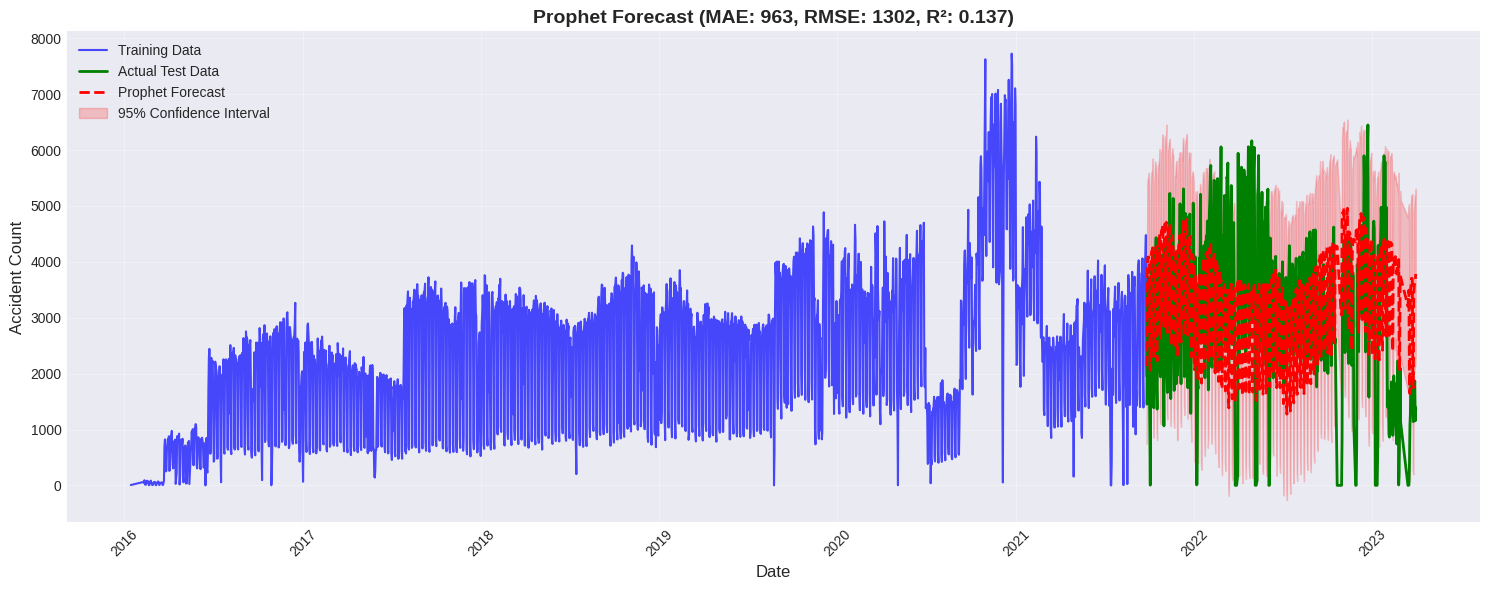


Prophet Component Analysis:


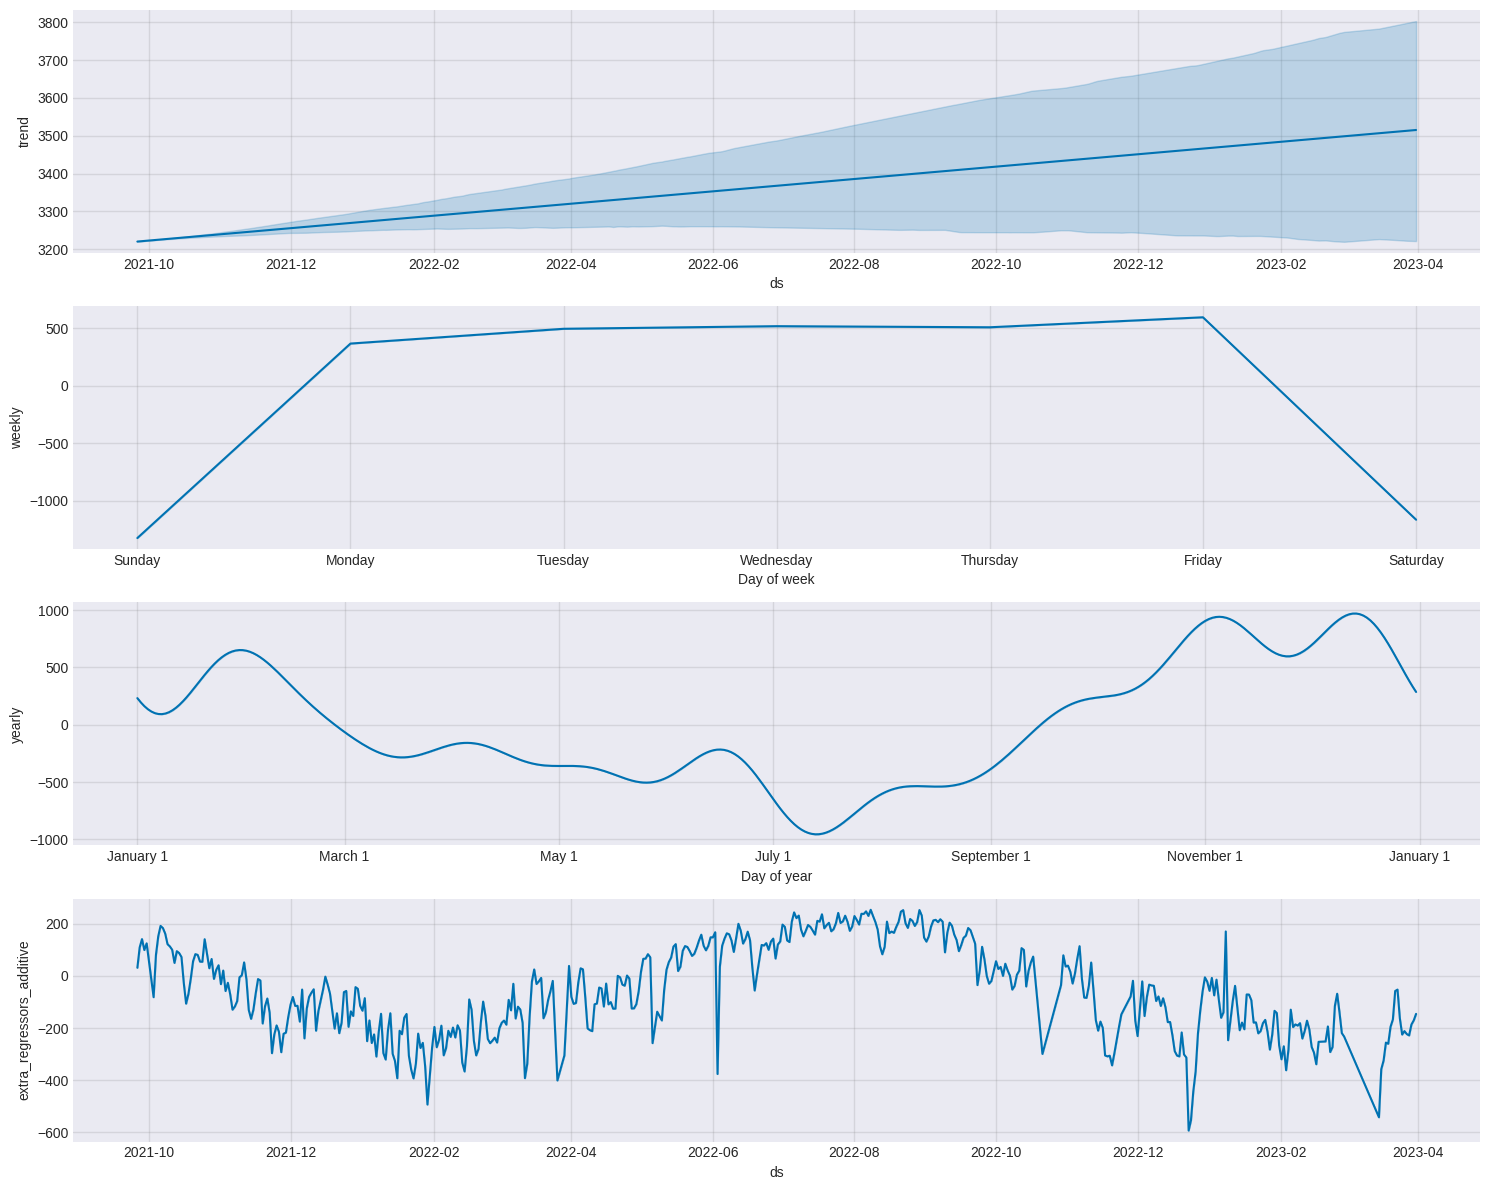


✅ Prophet analysis complete!


In [16]:
# Make predictions
print("\nGenerating Prophet predictions...")

future_prophet = test_prophet[['ds', 'Temperature', 'Humidity', 'Visibility', 'Weather_Risk']].copy()
prophet_forecast = prophet_model.predict(future_prophet)

prophet_predictions = prophet_forecast['yhat'].values

# Calculate metrics
prophet_mae = mean_absolute_error(test_prophet['y'], prophet_predictions)
prophet_rmse = np.sqrt(mean_squared_error(test_prophet['y'], prophet_predictions))
prophet_mape = np.mean(np.abs((test_prophet['y'] - prophet_predictions) / test_prophet['y'])) * 100
prophet_r2 = r2_score(test_prophet['y'], prophet_predictions)

print("\n" + "=" * 60)
print("PROPHET MODEL PERFORMANCE METRICS")
print("=" * 60)
print(f"  MAE:  {prophet_mae:,.2f} accidents/day")
print(f"  RMSE: {prophet_rmse:,.2f} accidents/day")
print(f"  MAPE: {prophet_mape:.2f}%")
print(f"  R²:   {prophet_r2:.4f}")

fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(train_prophet['ds'], train_prophet['y'],
        label='Training Data', color='blue', alpha=0.7)

ax.plot(test_prophet['ds'], test_prophet['y'],
        label='Actual Test Data', color='green', linewidth=2)

ax.plot(prophet_forecast['ds'], prophet_forecast['yhat'],
        label='Prophet Forecast', color='red', linestyle='--', linewidth=2)

ax.fill_between(prophet_forecast['ds'],
                prophet_forecast['yhat_lower'],
                prophet_forecast['yhat_upper'],
                alpha=0.2, color='red', label='95% Confidence Interval')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Accident Count', fontsize=12)
ax.set_title(f'Prophet Forecast (MAE: {prophet_mae:.0f}, RMSE: {prophet_rmse:.0f}, R²: {prophet_r2:.3f})',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nProphet Component Analysis:")
fig = prophet_model.plot_components(prophet_forecast, figsize=(15, 12))
plt.tight_layout()
plt.show()

print("\n✅ Prophet analysis complete!")

## 6. Baseline Model 3: Random Forest Regression

In [17]:
print("=" * 60)
print("BASELINE MODEL 3: Random Forest Regression")
print("=" * 60)

# Prepare features for Random Forest
rf_data = daily_accidents.copy()

rf_data = rf_data.dropna()

print(f"\nData after removing NaN: {rf_data.shape}")

feature_cols = [
    'Avg_Severity',
    'Avg_Temperature', 'Avg_Humidity', 'Avg_Visibility',
    'Avg_Wind_Speed', 'Avg_Precipitation',
    'Weather_Risk_Index',
    'Accident_Count_7d_MA', 'Accident_Count_30d_MA',
    'Accident_Count_7d_Std',
    'Accident_Count_Lag_1', 'Accident_Count_Lag_3',
    'Accident_Count_Lag_7', 'Accident_Count_Lag_14',
    'Avg_Temperature_Lag_1', 'Avg_Humidity_Lag_1',
    'Avg_Visibility_Lag_1'
]

X = rf_data[feature_cols]
y = rf_data['Accident_Count']

# Train-test split (80-20)
train_size_rf = int(len(X) * 0.8)
X_train, X_test = X[:train_size_rf], X[train_size_rf:]
y_train, y_test = y[:train_size_rf], y[train_size_rf:]

print(f"\nData split:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")
print(f"  Number of features: {X_train.shape[1]}")

print("\n⏳ Training Random Forest Regressor...")

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train, y_train)

print("\n✅ Random Forest model trained successfully!")

BASELINE MODEL 3: Random Forest Regression

Data after removing NaN: (2538, 23)

Data split:
  Training set: 2030 samples
  Test set: 508 samples
  Number of features: 17

⏳ Training Random Forest Regressor (this may take 2-5 minutes)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.1s



✅ Random Forest model trained successfully!


[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.7s finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished



Generating Random Forest predictions...

RANDOM FOREST MODEL PERFORMANCE METRICS
  MAE:  661.96 accidents/day
  RMSE: 935.81 accidents/day
  MAPE: 5324.85%
  R²:   0.5528

Top 10 Most Important Features:
              Feature  Importance
 Accident_Count_Lag_7    0.596623
Accident_Count_Lag_14    0.114285
 Accident_Count_7d_MA    0.105107
 Accident_Count_Lag_1    0.096285
         Avg_Severity    0.029283
Accident_Count_7d_Std    0.015679
Accident_Count_30d_MA    0.008161
    Avg_Precipitation    0.006314
       Avg_Wind_Speed    0.005348
 Accident_Count_Lag_3    0.005334


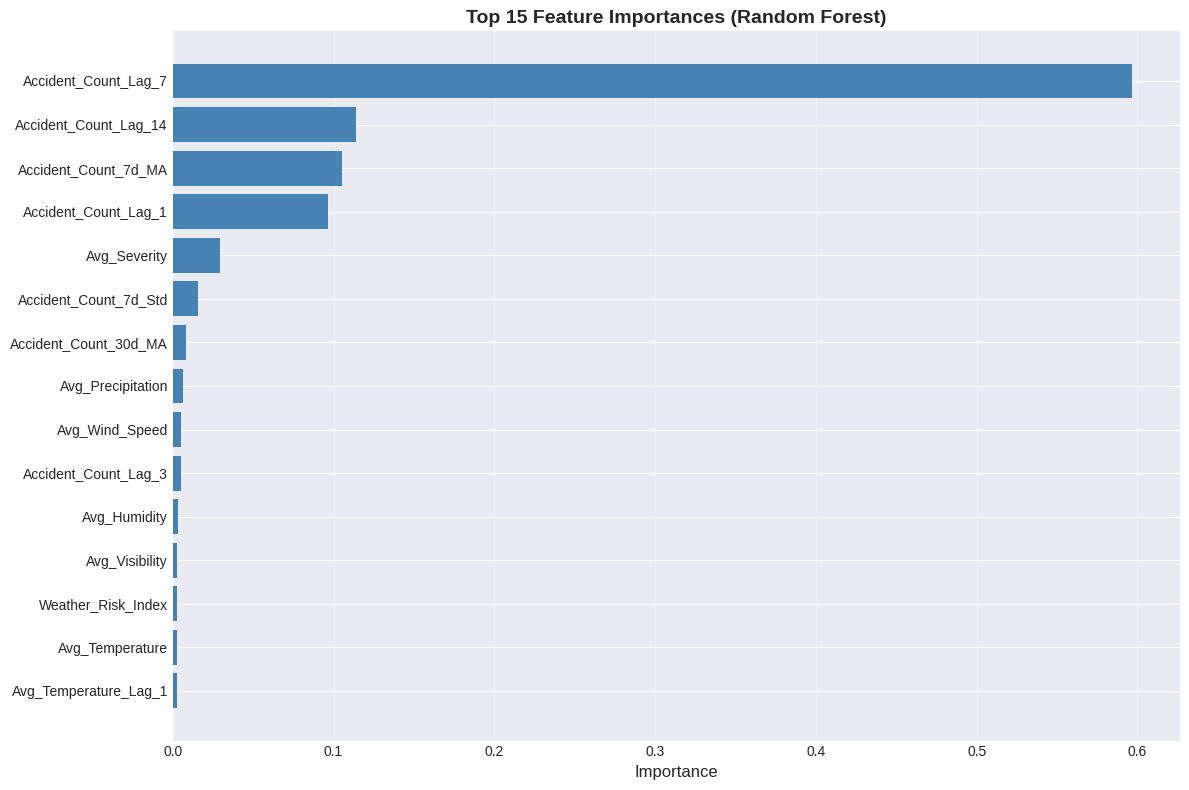

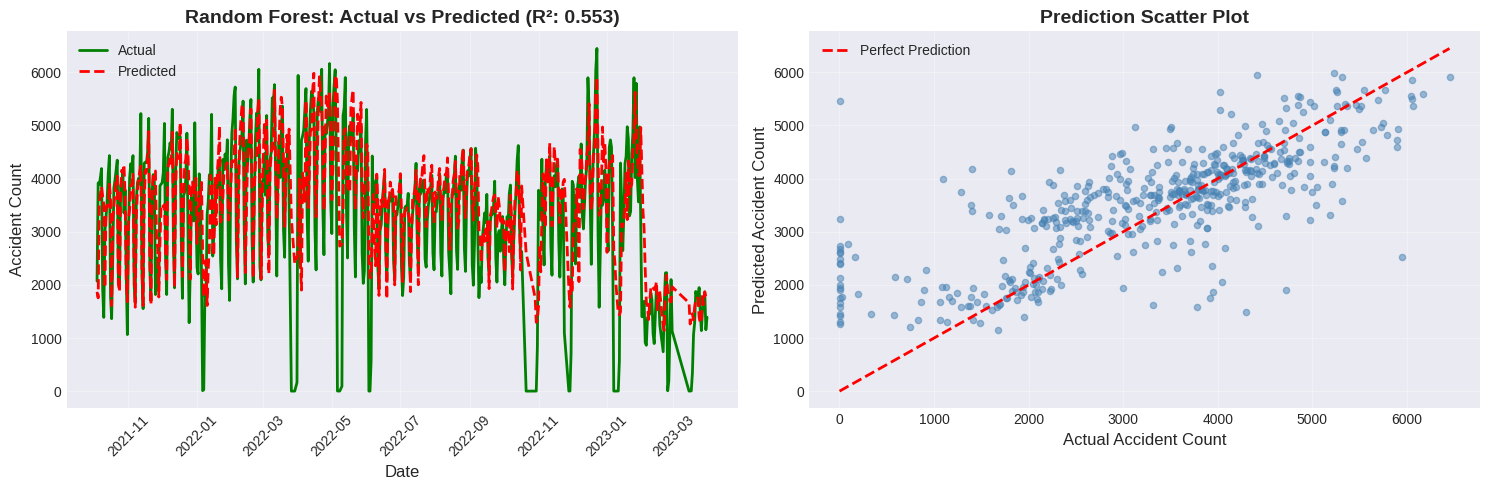


✅ Random Forest analysis complete!


In [18]:
# Make predictions
print("\nGenerating Random Forest predictions...")
rf_predictions = rf_model.predict(X_test)

# Calculate metrics
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_mape = np.mean(np.abs((y_test - rf_predictions) / y_test)) * 100
rf_r2 = r2_score(y_test, rf_predictions)

print("\n" + "=" * 60)
print("RANDOM FOREST MODEL PERFORMANCE METRICS")
print("=" * 60)
print(f"  MAE:  {rf_mae:,.2f} accidents/day")
print(f"  RMSE: {rf_rmse:,.2f} accidents/day")
print(f"  MAPE: {rf_mape:.2f}%")
print(f"  R²:   {rf_r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'][:15], feature_importance['Importance'][:15], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Predictions vs Actual
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Time series plot
test_dates = rf_data.iloc[train_size_rf:]['Date'].values
axes[0].plot(test_dates, y_test.values, label='Actual', linewidth=2, color='green')
axes[0].plot(test_dates, rf_predictions, label='Predicted', linestyle='--', linewidth=2, color='red')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Accident Count', fontsize=12)
axes[0].set_title(f'Random Forest: Actual vs Predicted (R²: {rf_r2:.3f})',
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45)

# Scatter plot
axes[1].scatter(y_test, rf_predictions, alpha=0.5, s=20, color='steelblue')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Accident Count', fontsize=12)
axes[1].set_ylabel('Predicted Accident Count', fontsize=12)
axes[1].set_title('Prediction Scatter Plot', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Random Forest analysis complete!")

## 7. Model Comparison and Summary

MODEL COMPARISON: BASELINE FORECASTING MODELS

        Model       MAE        RMSE    MAPE (%)       R²
      Prophet 963.08997 1302.118588 7278.146911 0.136573
Random Forest 661.96027  935.808029 5324.848864 0.552754

BEST PERFORMING MODEL BY METRIC:
  Lowest MAE:  Random Forest
  Lowest RMSE: Random Forest
  Highest R²:  Random Forest


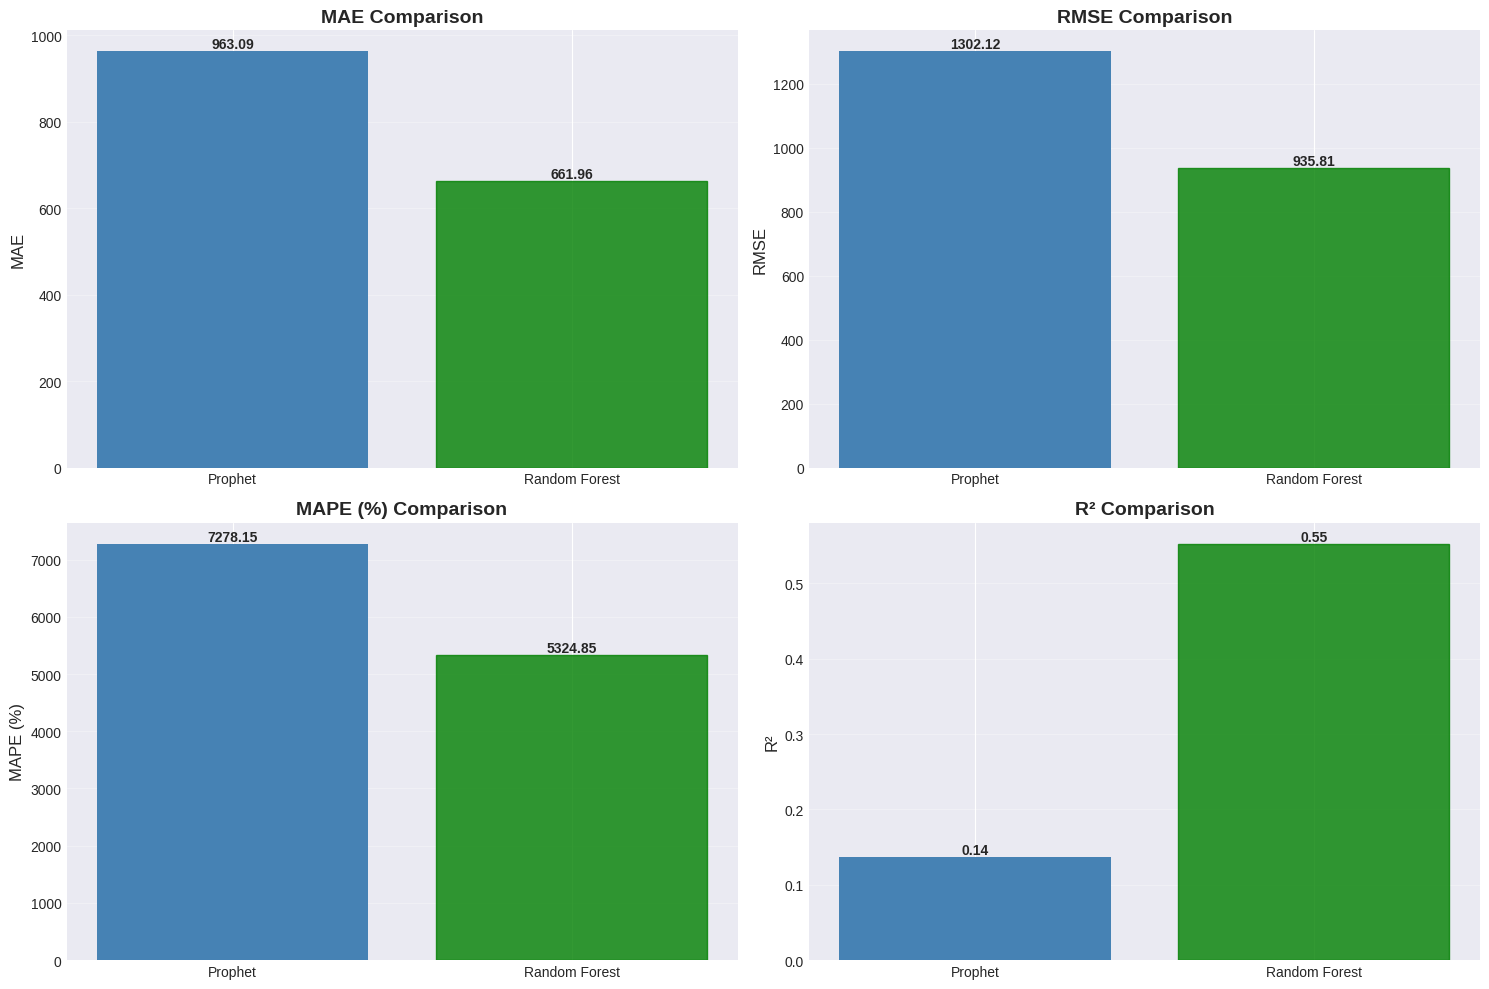


✅ Model comparison saved to: /content/model_comparison.csv

⚠️  Note: ARIMA removed due to compatibility issues. Results show Prophet vs Random Forest only.


In [19]:
print("=" * 70)
print("MODEL COMPARISON: BASELINE FORECASTING MODELS")
print("=" * 70)

comparison_df = pd.DataFrame({
    'Model': ['Prophet', 'Random Forest'],
    'MAE': [prophet_mae, rf_mae],
    'RMSE': [prophet_rmse, rf_rmse],
    'MAPE (%)': [prophet_mape, rf_mape],
    'R²': [prophet_r2, rf_r2]
})

print("\n" + comparison_df.to_string(index=False))

best_mae = comparison_df.loc[comparison_df['MAE'].idxmin(), 'Model']
best_rmse = comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Model']
best_r2 = comparison_df.loc[comparison_df['R²'].idxmax(), 'Model']

print("\n" + "=" * 70)
print("BEST PERFORMING MODEL BY METRIC:")
print("=" * 70)
print(f"  Lowest MAE:  {best_mae}")
print(f"  Lowest RMSE: {best_rmse}")
print(f"  Highest R²:  {best_r2}")

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['MAE', 'RMSE', 'MAPE (%)', 'R²']
colors = ['steelblue', 'steelblue']

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    if metric == 'R²':
        best_idx = comparison_df[metric].idxmax()
    else:
        best_idx = comparison_df[metric].idxmin()
    bars[best_idx].set_color('green')
    bars[best_idx].set_alpha(0.8)

    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Save comparison results
comparison_file = '/content/model_comparison.csv'
comparison_df.to_csv(comparison_file, index=False)
print(f"\n✅ Model comparison saved to: {comparison_file}")
print("\n⚠️  Note: ARIMA removed due to compatibility issues. Results show Prophet vs Random Forest only.")

## 8. Bonus: Severity Classification with Random Forest

BONUS: Severity Classification Model

Preparing data for severity classification...
  Training samples: 80,000
  Test samples: 20,000

⏳ Training Random Forest Classifier for severity...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s



✅ Classifier trained


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished



SEVERITY CLASSIFICATION RESULTS
  Accuracy: 0.6167 (61.67%)

Classification Report:
              precision    recall  f1-score   support

           1       0.05      0.52      0.09       168
           2       0.86      0.67      0.75     15919
           3       0.29      0.48      0.36      3370
           4       0.07      0.04      0.05       543

    accuracy                           0.62     20000
   macro avg       0.32      0.43      0.31     20000
weighted avg       0.73      0.62      0.66     20000



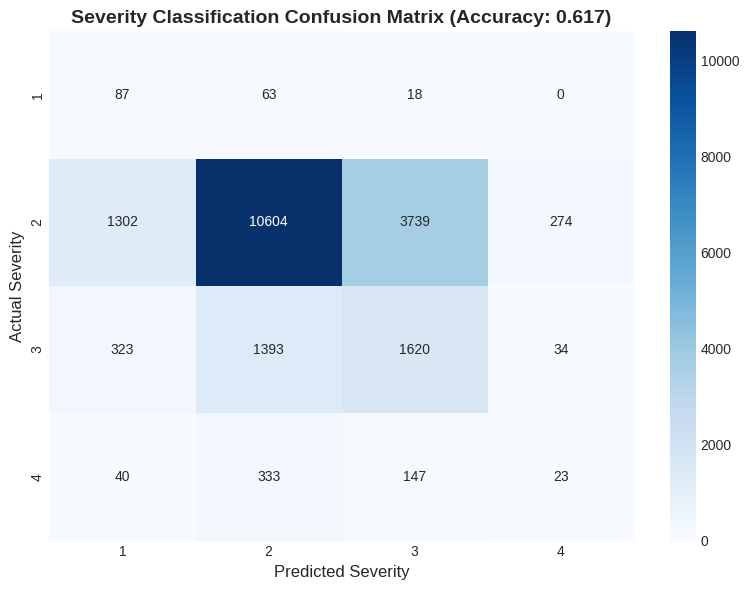

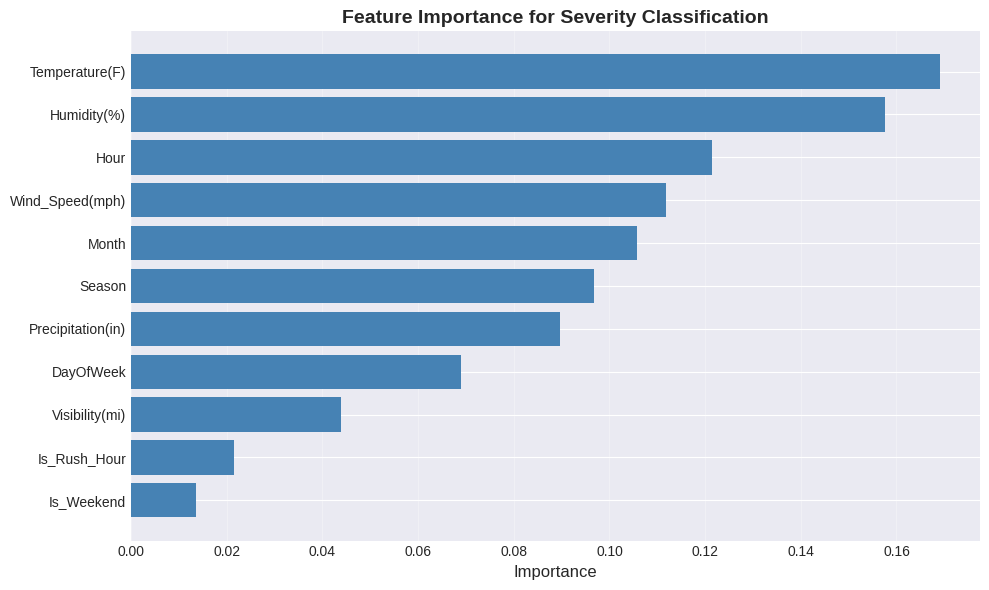


Top 5 Features for Severity Prediction:
        Feature  Importance
 Temperature(F)    0.169014
    Humidity(%)    0.157558
           Hour    0.121450
Wind_Speed(mph)    0.111727
          Month    0.105702

✅ Severity classification complete!


In [20]:
print("=" * 60)
print("BONUS: Severity Classification Model")
print("=" * 60)

# Use original dataframe with individual accidents
print("\nPreparing data for severity classification...")

# Select features
severity_features = [
    'Temperature(F)', 'Humidity(%)', 'Visibility(mi)',
    'Wind_Speed(mph)', 'Precipitation(in)',
    'Hour', 'DayOfWeek', 'Month', 'Season',
    'Is_Weekend', 'Is_Rush_Hour'
]

sample_size = min(100000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

X_severity = df_sample[severity_features]
y_severity = df_sample['Severity']

# Handle any remaining missing values
X_severity = X_severity.fillna(X_severity.median())

# Train-test split
X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(
    X_severity, y_severity, test_size=0.2, random_state=42, stratify=y_severity
)

print(f"  Training samples: {X_train_sev.shape[0]:,}")
print(f"  Test samples: {X_test_sev.shape[0]:,}")

# Train classifier
print("\n⏳ Training Random Forest Classifier for severity...")
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    verbose=1
)

rf_classifier.fit(X_train_sev, y_train_sev)
print("\n✅ Classifier trained")

# Predictions
y_pred_sev = rf_classifier.predict(X_test_sev)

# Metrics
accuracy = accuracy_score(y_test_sev, y_pred_sev)

print("\n" + "=" * 60)
print("SEVERITY CLASSIFICATION RESULTS")
print("=" * 60)
print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test_sev, y_pred_sev))

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_sev, y_pred_sev)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y_severity.unique()),
            yticklabels=sorted(y_severity.unique()))
plt.xlabel('Predicted Severity', fontsize=12)
plt.ylabel('Actual Severity', fontsize=12)
plt.title(f'Severity Classification Confusion Matrix (Accuracy: {accuracy:.3f})',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

severity_importance = pd.DataFrame({
    'Feature': severity_features,
    'Importance': rf_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(severity_importance['Feature'], severity_importance['Importance'], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.title('Feature Importance for Severity Classification', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop 5 Features for Severity Prediction:")
print(severity_importance.head().to_string(index=False))

print("\n✅ Severity classification complete!")